In [1]:
import os
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import (
    Xception, VGG16, VGG19, ResNet50V2, ResNet152V2, InceptionV3,
    MobileNetV2, MobileNetV3Small, EfficientNetV2B0
)
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess


In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = (224, 224)
SEED = 42
fine_tune_epochs = 10

train_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/train")
test_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/test")
val_dir = pathlib.Path("/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid")

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 5789 files belonging to 57 classes.
Found 1448 files belonging to 57 classes.
Found 1810 files belonging to 57 classes.


2024-10-23 18:41:35.800486: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-23 18:41:35.800519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-23 18:41:35.800526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-23 18:41:35.800539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-23 18:41:35.800550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

In [5]:
model_dict = {
    'Xception': (Xception, xception_preprocess),
    'VGG16': (VGG16, vgg16_preprocess),
    'VGG19': (VGG19, vgg19_preprocess),
    'ResNet50V2': (ResNet50V2, resnet_preprocess),
    'ResNet152V2': (ResNet152V2, resnet_preprocess),
    'InceptionV3': (InceptionV3, inception_preprocess),
    'MobileNetV2': (MobileNetV2, mobilenet_v2_preprocess),
    'MobileNetV3Small': (MobileNetV3Small, mobilenet_v3_preprocess),
    'EfficientNetV2B0': (EfficientNetV2B0, efficientnet_preprocess),
}


In [7]:
models_and_histories = {}
base_learning_rate = 0.0001

for model_name, (model_class, preprocess_input) in model_dict.items():
    print(f"Training model: {model_name}")
    
    # Create base model
    base_model = model_class(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    # Build the model
    inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds
    )
    
    # Fine-tuning
    base_model.trainable = True
    #fine_tune_at = 100
    
    for layer in base_model.layers[:-70]:
        layer.trainable = False
    
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    total_epochs = EPOCHS + fine_tune_epochs
    history_fine = model.fit(
        train_ds,
        epochs=total_epochs,
        initial_epoch=history.epoch[-1],
        validation_data=val_ds
    )
    
    # Store model and its history
    models_and_histories[model_name] = {
        'model': model,
        'history': history,
        'history_fine': history_fine
    }

Training model: Xception
Epoch 1/10


2024-10-23 18:41:52.101121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 307ms/step - accuracy: 0.0918 - loss: 3.7936 - val_accuracy: 0.2645 - val_loss: 3.1364
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 307ms/step - accuracy: 0.2811 - loss: 3.0798 - val_accuracy: 0.4081 - val_loss: 2.6419
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.3975 - loss: 2.6573 - val_accuracy: 0.4731 - val_loss: 2.3082
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.4703 - loss: 2.3461 - val_accuracy: 0.5276 - val_loss: 2.0712
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 309ms/step - accuracy: 0.5290 - loss: 2.1195 - val_accuracy: 0.5718 - val_loss: 1.8941
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 313ms/step - accuracy: 0.5733 - loss: 1.9295 - val_accuracy: 0.6140 - val_loss: 1.7519
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 54s 298ms/step - accuracy: 0.6065 - loss: 1.7934 - val_accuracy: 0.6319 - val_loss: 1.6449
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 304ms/step - accuracy: 0.6319 - loss: 1.6861 - val

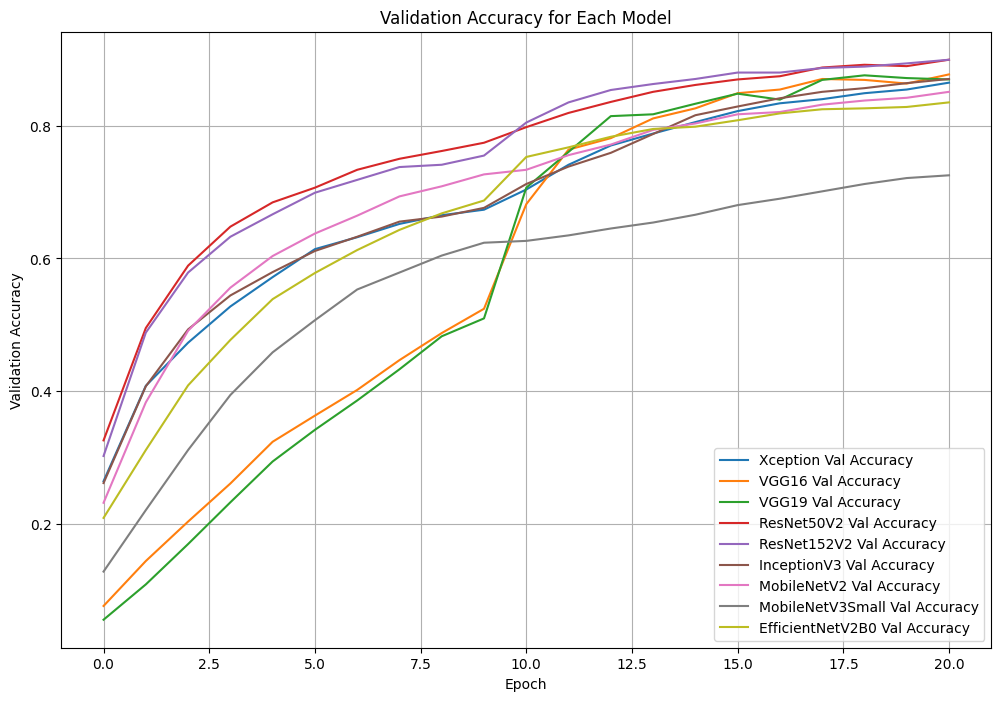

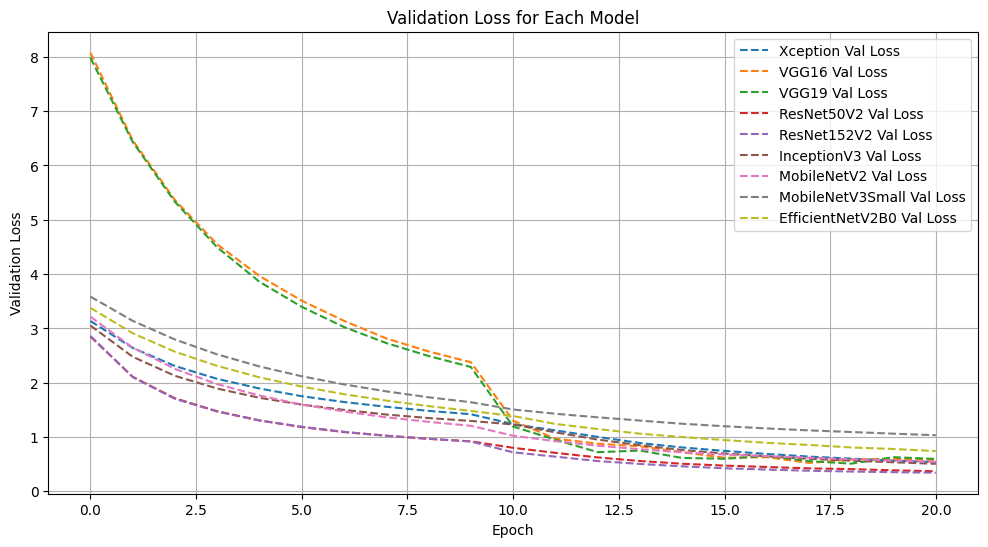

In [26]:
# Plot validation accuracy for each model
plt.figure(figsize=(12, 8))
for model_name, data in models_and_histories.items():
    history = data['history']
    history_fine = data['history_fine']
    
    # Combine history from training and fine-tuning
    acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    
    # Plot accuracy
    plt.plot(acc, label=f'{model_name} Val Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot validation loss for each model
plt.figure(figsize=(12, 6))
for model_name, data in models_and_histories.items():
    history = data['history']
    history_fine = data['history_fine']
    
    # Combine history from training and fine-tuning
    loss = history.history['val_loss'] + history_fine.history['val_loss']
    
    # Plot loss
    plt.plot(loss, label=f'{model_name} Val Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Each Model')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [9]:

for model_name, data in models_and_histories.items():
    model = data['model']
    loss, accuracy = model.evaluate(test_ds)
    print(f'{model_name} - Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.8658 - loss: 0.5552
Xception - Test Accuracy: 0.8713, Test Loss: 0.5267
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.8664 - loss: 0.6362
VGG16 - Test Accuracy: 0.8724, Test Loss: 0.6019
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step - accuracy: 0.8843 - loss: 0.5464
VGG19 - Test Accuracy: 0.8768, Test Loss: 0.5993
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9056 - loss: 0.3558
ResNet50V2 - Test Accuracy: 0.9116, Test Loss: 0.3252
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 414ms/step - accuracy: 0.8859 - loss: 0.4010
ResNet152V2 - Test Accuracy: 0.9011, Test Loss: 0.3572
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8580 - loss: 0.5191
InceptionV3 - Test Accuracy: 0.8641, Test Loss: 0.5046
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.8467 - loss: 0.5590
MobileNetV2 - Test Accuracy: 0.8503, Test Loss: 0.5409
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7505 - loss: 0.9797
MobileNetV3Small - Test Accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

2024-10-24 08:49:04.419739: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

2024-10-24 08:49:20.117709: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

2024-10-24 08:49:55.536389: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2024-10-24 08:51:27.751240: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

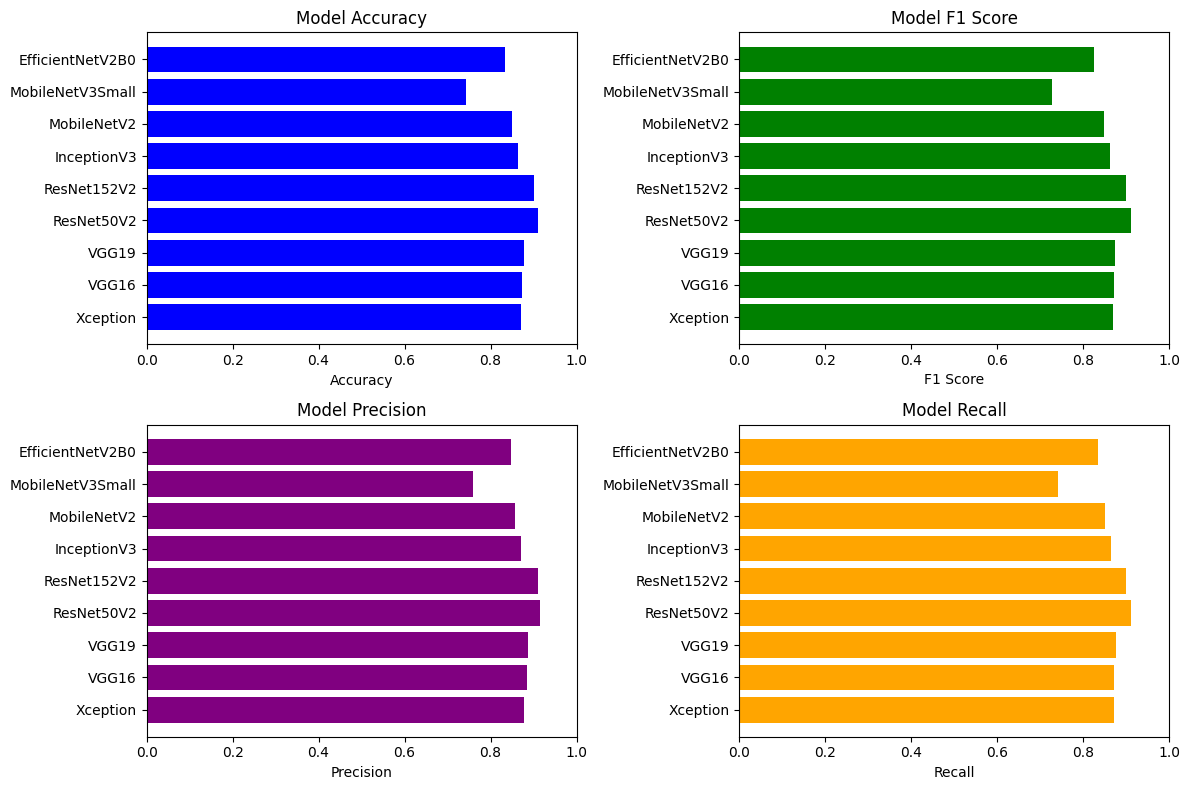

In [11]:
# %% [markdown]
# # Imports

# %%
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# %% [markdown]
# # Evaluate and Store Metrics

# %%
# Initialize a dictionary to store the metrics
metrics_dict = {
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'recall': []
}

# Collect metrics for each model
for model_name, data in models_and_histories.items():
    model = data['model']
    
    # Get true labels and predictions for the test set
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    # Store the metrics in the models_and_histories dictionary
    models_and_histories[model_name]['metrics'] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall
    }
    
    # Append the metrics for bar plotting
    metrics_dict['accuracy'].append(accuracy)
    metrics_dict['f1_score'].append(f1)
    metrics_dict['precision'].append(precision)
    metrics_dict['recall'].append(recall)

# Add the model names for reference
model_names = list(models_and_histories.keys())


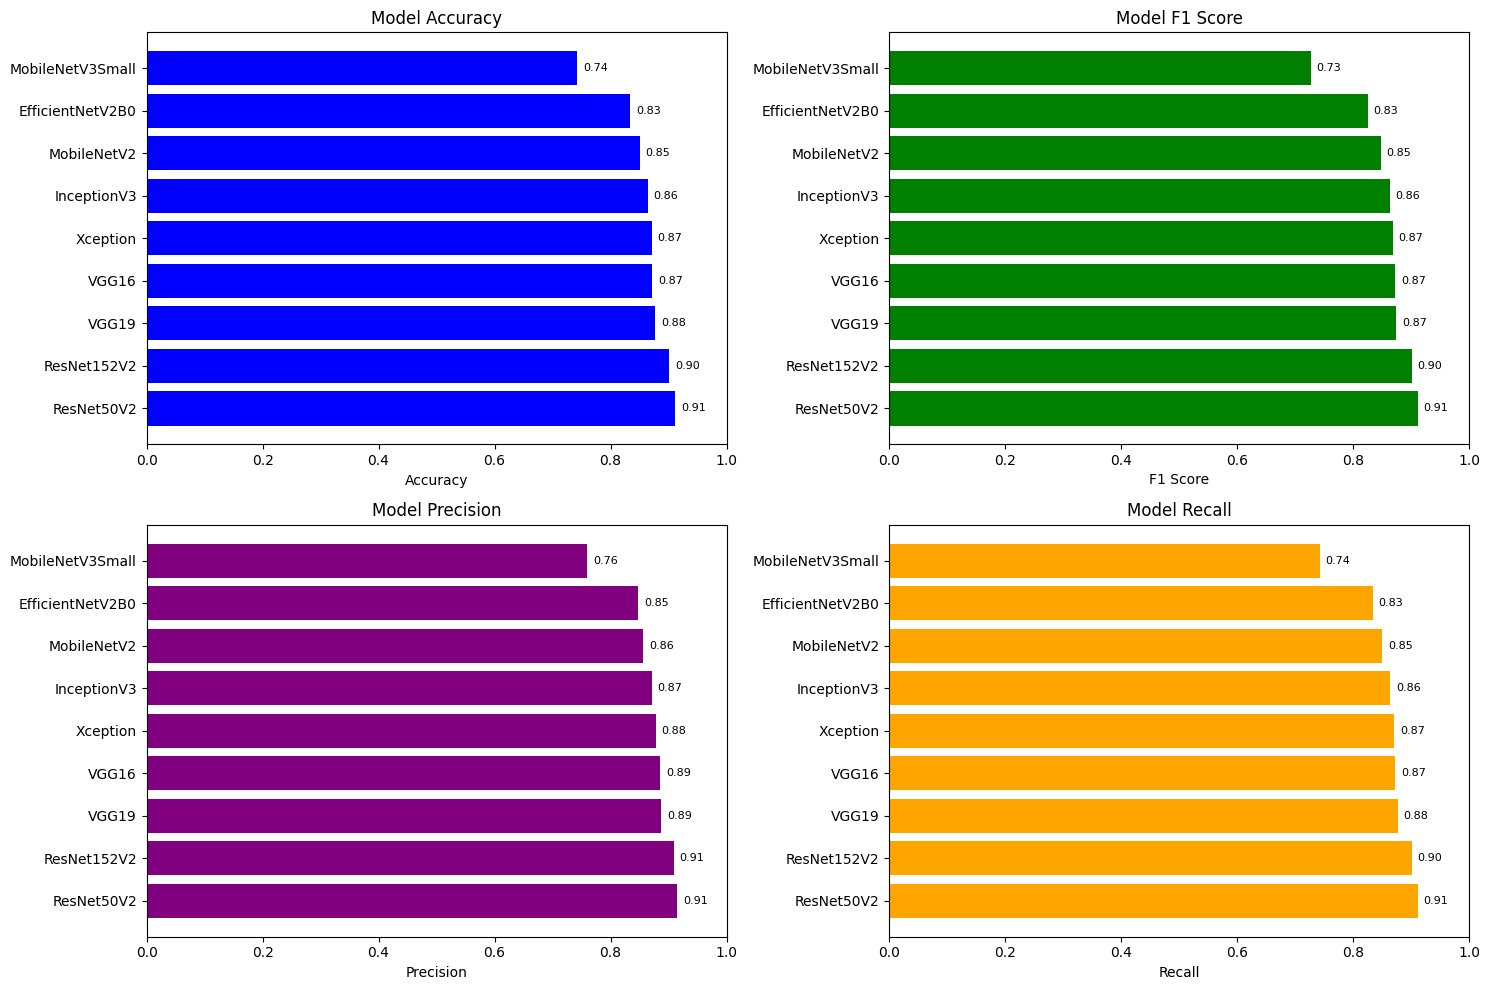

In [14]:
# Sort models by each metric and create bar plots with values displayed
plt.figure(figsize=(15, 10))

# Define a function to create sorted bar plots with values
def plot_sorted_barh(ax, metric_name, values, color):
    # Sort the values and corresponding model names
    sorted_indices = np.argsort(values)[::-1]
    sorted_values = np.array(values)[sorted_indices]
    sorted_model_names = np.array(model_names)[sorted_indices]
    
    # Create the bar plot
    ax.barh(sorted_model_names, sorted_values, color=color)
    ax.set_xlabel(metric_name)
    ax.set_title(f'Model {metric_name}')
    ax.set_xlim([0, 1])
    
    # Add the values as labels on the bars
    for i, v in enumerate(sorted_values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=8)

# Plot Accuracy
ax1 = plt.subplot(2, 2, 1)
plot_sorted_barh(ax1, 'Accuracy', metrics_dict['accuracy'], 'blue')

# Plot F1 Score
ax2 = plt.subplot(2, 2, 2)
plot_sorted_barh(ax2, 'F1 Score', metrics_dict['f1_score'], 'green')

# Plot Precision
ax3 = plt.subplot(2, 2, 3)
plot_sorted_barh(ax3, 'Precision', metrics_dict['precision'], 'purple')

# Plot Recall
ax4 = plt.subplot(2, 2, 4)
plot_sorted_barh(ax4, 'Recall', metrics_dict['recall'], 'orange')

plt.tight_layout()
plt.show()

In [16]:
# %% [markdown]
# # Evaluate and Store Metrics (Before and After Fine-Tuning)

# %%
# Initialize dictionaries to store the metrics
pre_fine_tuning_metrics_dict = {
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'recall': []
}

post_fine_tuning_metrics_dict = {
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'recall': []
}

# Collect metrics for each model before and after fine-tuning
for model_name, data in models_and_histories.items():
    # Get the trained model and the histories
    model = data['model']
    history = data['history']

    # Evaluate the model on test data before fine-tuning
    print(f"Evaluating {model_name} before fine-tuning...")
    y_true = []
    y_pred_pre = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred_pre.extend(np.argmax(predictions, axis=1))

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred_pre = np.array(y_pred_pre)

    # Calculate metrics before fine-tuning
    accuracy_pre = accuracy_score(y_true, y_pred_pre)
    f1_pre = f1_score(y_true, y_pred_pre, average='weighted')
    precision_pre = precision_score(y_true, y_pred_pre, average='weighted')
    recall_pre = recall_score(y_true, y_pred_pre, average='weighted')

    # Store the pre-fine-tuning metrics in the dictionary
    pre_fine_tuning_metrics_dict['accuracy'].append(accuracy_pre)
    pre_fine_tuning_metrics_dict['f1_score'].append(f1_pre)
    pre_fine_tuning_metrics_dict['precision'].append(precision_pre)
    pre_fine_tuning_metrics_dict['recall'].append(recall_pre)

    # Evaluate the model after fine-tuning
    print(f"Evaluating {model_name} after fine-tuning...")
    y_pred_post = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred_post.extend(np.argmax(predictions, axis=1))

    # Convert lists to numpy arrays
    y_pred_post = np.array(y_pred_post)

    # Calculate metrics after fine-tuning
    accuracy_post = accuracy_score(y_true, y_pred_post)
    f1_post = f1_score(y_true, y_pred_post, average='weighted')
    precision_post = precision_score(y_true, y_pred_post, average='weighted')
    recall_post = recall_score(y_true, y_pred_post, average='weighted')

    # Store the post-fine-tuning metrics in the dictionary
    post_fine_tuning_metrics_dict['accuracy'].append(accuracy_post)
    post_fine_tuning_metrics_dict['f1_score'].append(f1_post)
    post_fine_tuning_metrics_dict['precision'].append(precision_post)
    post_fine_tuning_metrics_dict['recall'].append(recall_post)

    # Store both pre- and post-fine-tuning metrics in models_and_histories
    models_and_histories[model_name]['metrics_pre'] = {
        'accuracy': accuracy_pre,
        'f1_score': f1_pre,
        'precision': precision_pre,
        'recall': recall_pre
    }
    models_and_histories[model_name]['metrics_post'] = {
        'accuracy': accuracy_post,
        'f1_score': f1_post,
        'precision': precision_post,
        'recall': recall_post
    }


Evaluating Xception before fine-tuning...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━

2024-10-24 09:30:28.113287: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_hierarchical_confusion_matrix(model, test_ds, class_names_family, class_names_genus, class_names_species):
    """
    Compute and display hierarchical confusion matrices for family, genus, and species.
    
    Args:
        model: The trained multi-output model that predicts family, genus, and species.
        test_ds: A TensorFlow dataset containing test images and labels.
        class_names_family: List of class names for family.
        class_names_genus: List of class names for genus.
        class_names_species: List of class names for species.
    """
    # Collect true labels and predictions
    y_true_family = []
    y_true_genus = []
    y_true_species = []
    y_pred_family = []
    y_pred_genus = []
    y_pred_species = []

    for images, (family_labels, genus_labels, species_labels) in test_ds:
        # Get model predictions
        family_preds, genus_preds, species_preds = model.predict(images)
        
        # Convert to class indices
        family_preds = np.argmax(family_preds, axis=1)
        genus_preds = np.argmax(genus_preds, axis=1)
        species_preds = np.argmax(species_preds, axis=1)
        
        # Convert true labels to class indices
        family_true = np.argmax(family_labels, axis=1)
        genus_true = np.argmax(genus_labels, axis=1)
        species_true = np.argmax(species_labels, axis=1)

        # Store results
        y_true_family.extend(family_true)
        y_true_genus.extend(genus_true)
        y_true_species.extend(species_true)
        y_pred_family.extend(family_preds)
        y_pred_genus.extend(genus_preds)
        y_pred_species.extend(species_preds)

    # Compute confusion matrices for each level
    cm_family = confusion_matrix(y_true_family, y_pred_family, labels=range(len(class_names_family)))
    cm_genus = confusion_matrix(y_true_genus, y_pred_genus, labels=range(len(class_names_genus)))
    cm_species = confusion_matrix(y_true_species, y_pred_species, labels=range(len(class_names_species)))

    # Display the confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Family-level confusion matrix
    ConfusionMatrixDisplay(cm_family, display_labels=class_names_family).plot(
        ax=axes[0], cmap='Blues', xticks_rotation=45
    )
    axes[0].set_title('Family Confusion Matrix')

    # Genus-level confusion matrix
    ConfusionMatrixDisplay(cm_genus, display_labels=class_names_genus).plot(
        ax=axes[1], cmap='Greens', xticks_rotation=45
    )
    axes[1].set_title('Genus Confusion Matrix')

    # Species-level confusion matrix
    ConfusionMatrixDisplay(cm_species, display_labels=class_names_species).plot(
        ax=axes[2], cmap='Oranges', xticks_rotation=45
    )
    axes[2].set_title('Species Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `model` is your trained model and `test_ds` is your test dataset.
# Also, `family_labels`, `genus_labels`, and `species_labels` should be the lists of class names for each taxonomic level.
plot_hierarchical_confusion_matrix(
    model,
    test_ds,
    class_names_family=family_labels,
    class_names_genus=genus_labels,
    class_names_species=species_labels
)

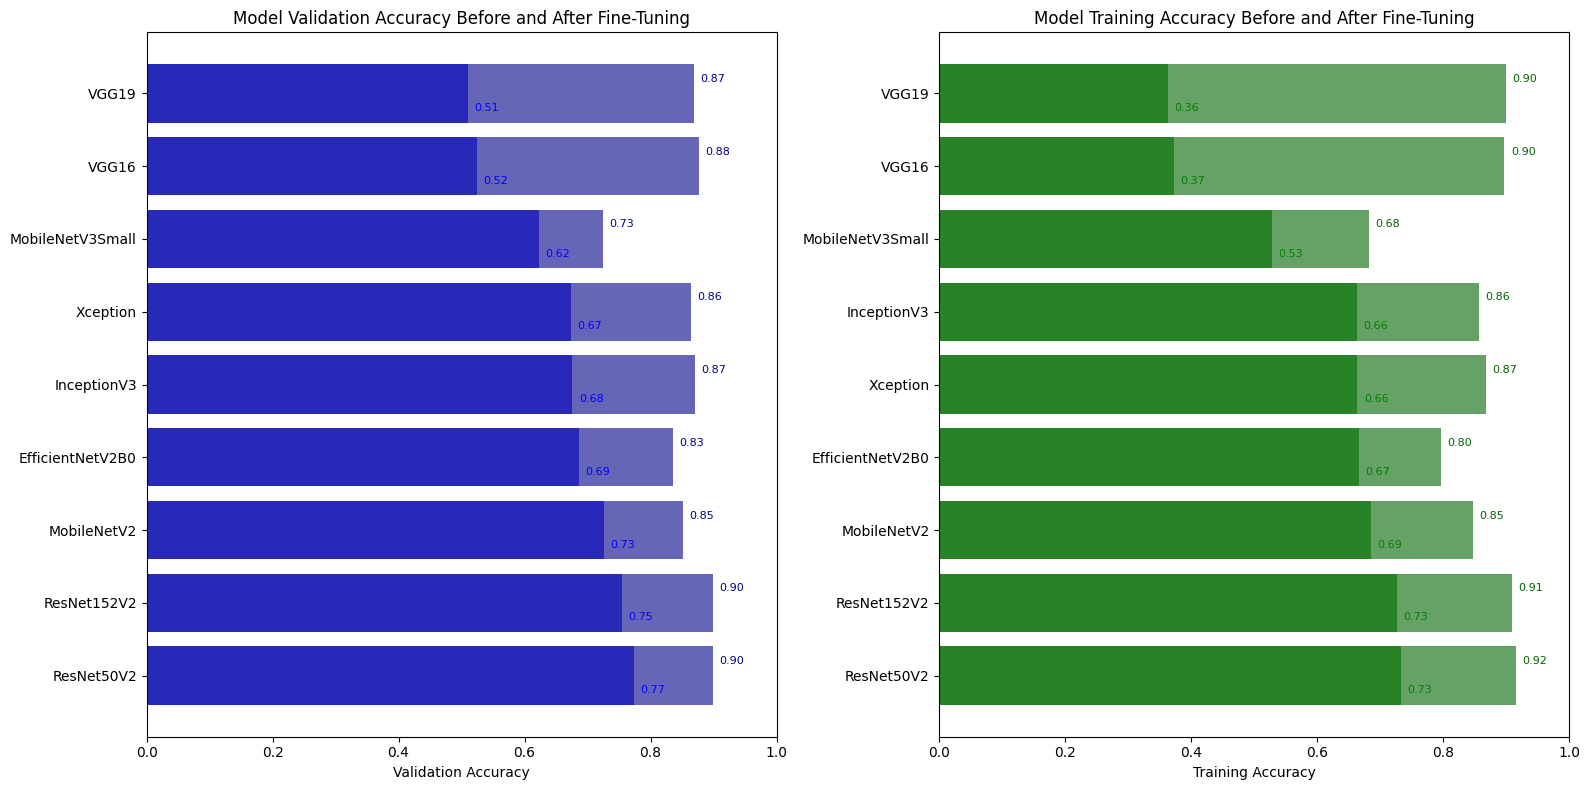

In [24]:
# %% [markdown]
# # Plot Metrics Before and After Fine-Tuning Using History

# %%
# Create bar plots for each metric before and after fine-tuning using training history
plt.figure(figsize=(16, 8))

# Define a function to create sorted bar plots with values
def plot_sorted_barh_from_history(ax, metric_name, history_key, color_pre, color_post):
    # Extract final validation accuracy before and after fine-tuning
    pre_values = [data['history'].history[history_key][-1] for data in models_and_histories.values()]
    post_values = [data['history_fine'].history[history_key][-1] for data in models_and_histories.values()]
    
    # Sort the values and corresponding model names based on pre-values
    sorted_indices = np.argsort(pre_values)[::-1]
    sorted_pre_values = np.array(pre_values)[sorted_indices]
    sorted_post_values = np.array(post_values)[sorted_indices]
    sorted_model_names = np.array(model_names)[sorted_indices]
    
    # Create the bar plot for pre-fine-tuning
    ax.barh(sorted_model_names, sorted_pre_values, color=color_pre, alpha=0.6, label=f'Pre {metric_name}')
    # Create the bar plot for post-fine-tuning with a slight offset for better readability
    ax.barh(sorted_model_names, sorted_post_values, color=color_post, alpha=0.6, label=f'Post {metric_name}')
    
    ax.set_xlabel(metric_name)
    ax.set_title(f'Model {metric_name} Before and After Fine-Tuning')
    ax.set_xlim([0, 1])
    
    # Add the values as labels on the bars for pre-fine-tuning
    for i, v in enumerate(sorted_pre_values):
        ax.text(v + 0.01, i - 0.2, f"{v:.2f}", va='center', fontsize=8, color=color_pre)
    # Add the values as labels on the bars for post-fine-tuning
    for i, v in enumerate(sorted_post_values):
        ax.text(v + 0.01, i + 0.2, f"{v:.2f}", va='center', fontsize=8, color=color_post)

# Plot Validation Accuracy
ax1 = plt.subplot(1, 2, 1)
plot_sorted_barh_from_history(ax1, 'Validation Accuracy', 'val_accuracy', 'blue', 'darkblue')

# Plot Training Accuracy
ax2 = plt.subplot(1, 2, 2)
plot_sorted_barh_from_history(ax2, 'Training Accuracy', 'accuracy', 'green', 'darkgreen')

# Adjust layout and show the plots
plt.tight_layout()
#plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.5))
plt.show()

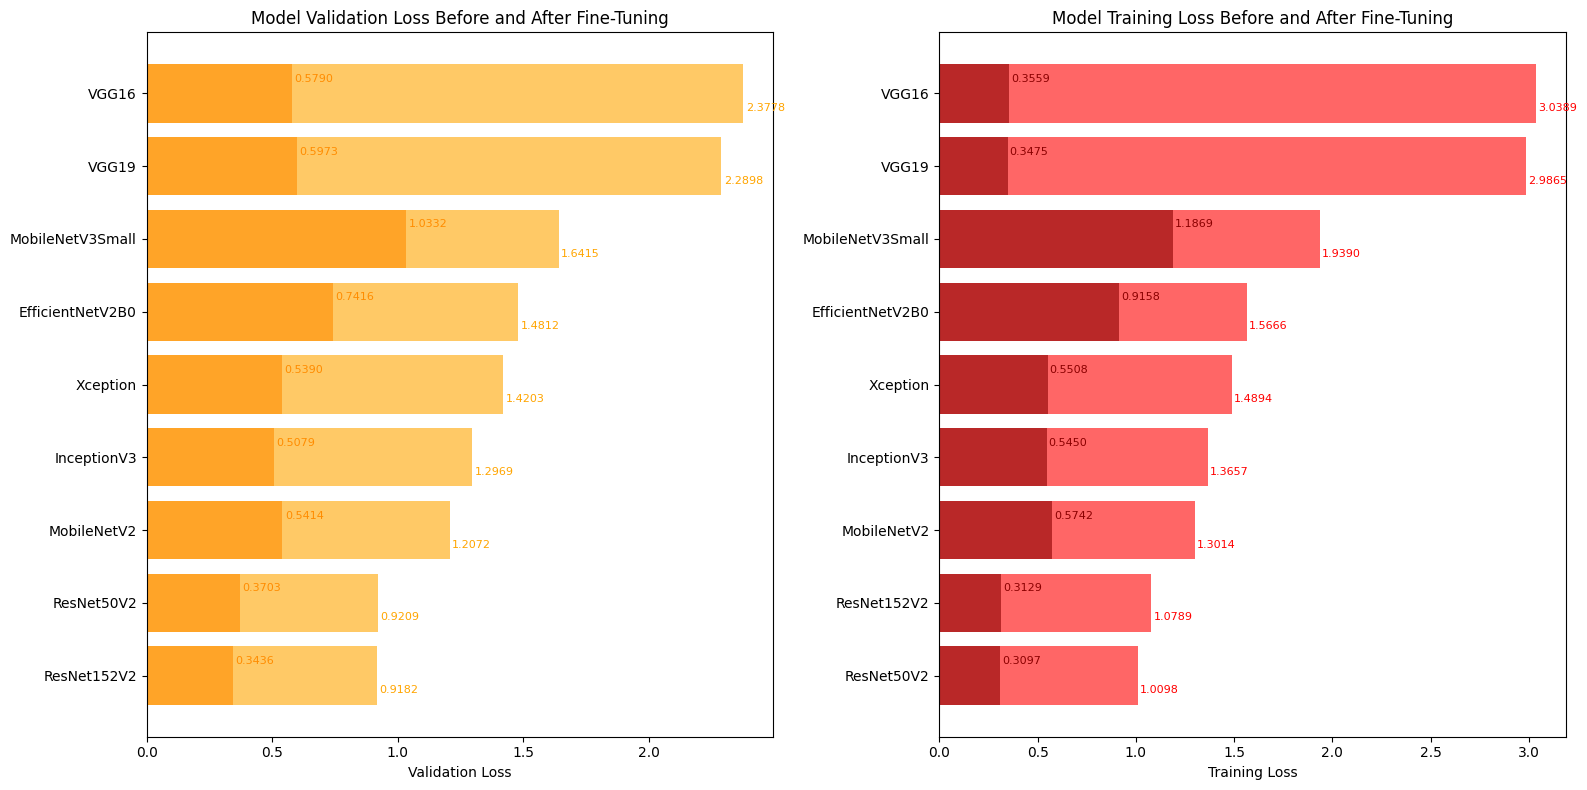

In [25]:
# %% [markdown]
# # Plot Loss Before and After Fine-Tuning Using History

# %%
# Create bar plots for training loss and validation loss before and after fine-tuning using training history
plt.figure(figsize=(16, 8))

# Define a function to create sorted bar plots with values for loss
def plot_sorted_barh_from_history_loss(ax, metric_name, history_key, color_pre, color_post):
    # Extract final loss values before and after fine-tuning
    pre_values = [data['history'].history[history_key][-1] for data in models_and_histories.values()]
    post_values = [data['history_fine'].history[history_key][-1] for data in models_and_histories.values()]
    
    # Sort the values and corresponding model names based on pre-values
    sorted_indices = np.argsort(pre_values)  # Sort ascending for loss (lower is better)
    sorted_pre_values = np.array(pre_values)[sorted_indices]
    sorted_post_values = np.array(post_values)[sorted_indices]
    sorted_model_names = np.array(model_names)[sorted_indices]
    
    # Create the bar plot for pre-fine-tuning
    ax.barh(sorted_model_names, sorted_pre_values, color=color_pre, alpha=0.6, label=f'Pre {metric_name}')
    # Create the bar plot for post-fine-tuning with a slight offset for better readability
    ax.barh(sorted_model_names, sorted_post_values, color=color_post, alpha=0.6, label=f'Post {metric_name}')
    
    ax.set_xlabel(metric_name)
    ax.set_title(f'Model {metric_name} Before and After Fine-Tuning')
    
    # Add the values as labels on the bars for pre-fine-tuning
    for i, v in enumerate(sorted_pre_values):
        ax.text(v + 0.01, i - 0.2, f"{v:.4f}", va='center', fontsize=8, color=color_pre)
    # Add the values as labels on the bars for post-fine-tuning
    for i, v in enumerate(sorted_post_values):
        ax.text(v + 0.01, i + 0.2, f"{v:.4f}", va='center', fontsize=8, color=color_post)

# Plot Validation Loss
ax1 = plt.subplot(1, 2, 1)
plot_sorted_barh_from_history_loss(ax1, 'Validation Loss', 'val_loss', 'orange', 'darkorange')

# Plot Training Loss
ax2 = plt.subplot(1, 2, 2)
plot_sorted_barh_from_history_loss(ax2, 'Training Loss', 'loss', 'red', 'darkred')

# Adjust layout and show the plots
plt.tight_layout()
#plt.legend(loc='lower right', bbox_to_anchor=(1.2, 0.5))
plt.show()

In [8]:
x = 0.1254643241

f'{int(x*10_000)}'

'1254'